# Desarrollo de modelos de machine learning

# Importación de librerías para análisis de machine learning

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

#   Mapeo de variables, Funciones, variables de entorno
Se definen funciones importantes para el desarrollo del análisis exploratorio y mapeo de variables para interpretabiliad humana.

## Variables de entorno
- data_sample : porcentaje de registros con los que se va a realizar análisis (entre 0 y 1).

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100

dict_columns = {
            'Time':'Time (min)',
            'Temperature':'Tin/amb (°C)',
            'ProcessTemperature':'ProcessTemperature (°C)',
            'AgentType':'AgentType',
            'AgentFlow':'AgentFlow (L/min)',
            'SampleType':'SampleType',
            'CatalystType':'CatalystType',
            'CatalystRatio':'CatalystRatio (%)',
            'CarbonMonoxide':'CarbonMonoxide (vol%)',
            'CarbonDioxide':'CarbonDioxide (vol%)',
            'Methane':'Methane (vol%)',
            'Oxygen':'Oxygen (vol%)',
            'Hydrogen':'Hydrogen (vol%)',
            'CalorificValue':'CalorificValue (kcal/m3)'
        }

data_sample = 3748/3748

# Etapas de desarrollo de modelo de machine learning :

1. Definir problema y métrica.
2. limpiar datos, Validación de datos + higiene determinística mínima - (Tomado de la etapa de ciencia de datos)
3. Manejo de desbalance. Desbalance (class_weight/SMOTE en pipeline y dentro de CV) (Verificado en etapa de ciencia de datos)
4. Particionar train/valid/test (o CV; para series temporales, split por tiempo). Split (train/valid/test; estratificado/por tiempo/grupo)
5. Baseline.
6. Pipeline de preprocesamiento/FE (fit solo en train) (imputación, codificación, escalado, outliers, selección)
7. Validación de datos y fuga de datos.
8. Preprocesamiento imputación, codificación, escalado (solo si aplica) en Pipeline.
9. Ingeniería de variables y selección de variables.
10. (Opcional) PCA tras escalar; evaluar varianza explicada/impacto.
11. Entrenamiento y tuning con CV/nested CV; early stopping si aplica. Selección y optimización de modelos con CV/nested CV (incluye boosting)
12. Calibración y ajuste de umbral. (solo para predicción de variables categóricas)
13. Evaluación en test + IC.
14. Interpretabilidad y análisis de errores.
15. Empaquetado, versionado, reproducibilidad y monitoreo.

# 1. Definir problema y métrica.

Se desea confirmar si KNN es el mejor modelo de machine learning que predice las composiciones de gas hidrogeno y metano dependiente de condiciones de operación de gasificación. Se realizaron análisis previos con ciencia de datos y se concluye que los datos cuentan con coherencia, sin anormalidades en el comportamiento de sus registros. El objetivo es tambien verificar los puntajes que se pueden obtener de otros modelos de machine learning.

# 2. Limpieza de datos, validación y control de calidad de los datos

Esta estapa se realiza en análisis de ciencia de datos:
- verificar que no hayan registros
- verificar que no hayan columnas duplicadas
- variables categóricas normalizadas (es decir, no tener distintos valores para un mismo valor)
- no tener datos nulos (solucionar con imputación), correción de errores tipográficos
- comportamiento coherente entre variables según los comportamientos reales
- que no existan valores incoherentes (temperaturas negativas, composiciones fuera del rango 0-1)
- examinar outliers incoherentes y dar pretatamiento a estos casos


# 3. Manejo de desbalance. Desbalance (class_weight/SMOTE en pipeline y dentro de CV) (Verificado en etapa de ciencia de datos)
Se deben evaluar desbalance de datos en variables categóricas, es decir, que en el conjunto de datos, los valores categóricos esten proporcionalmente equilibrados respecto a la cantidad total de registros, para que el modelo no desarrolle preferencia por alguna variable categórica.

# 4. Particionar train/valid/test 
- o CV; para series temporales, split por tiempo: no aplica, ya que no son series de tiempo

En esta etapa se realiza separación de conjunto de datos de entrenamiento y de testing.

In [3]:
df_original = pd.read_csv("../data/raw/kaggle_GasificationDataset.csv",sep=";")
df_original = df_original.sample(frac=data_sample, random_state=1307)
df_original.rename(columns=dict_columns, inplace=True)

target = [
    'CarbonMonoxide (vol%)',
    'CarbonDioxide (vol%)',
    'Methane (vol%)',
    'Oxygen (vol%)',
    'Hydrogen (vol%)',
    'CalorificValue (kcal/m3)'
]

cat_cols = df_original.select_dtypes(include="object").columns
df_original[cat_cols] = df_original[cat_cols].astype("category")

X = df_original.drop(columns=target)
y = df_original[target]

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

print("Categóricas:", categorical_cols)
print("Numéricas  :", numeric_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1307)


Categóricas: ['AgentType', 'SampleType', 'CatalystType']
Numéricas  : ['Time (min)', 'Tin/amb (°C)', 'ProcessTemperature (°C)', 'AgentFlow (L/min)', 'CatalystRatio (%)']


# 5. Baseline.

Es la implementación de un modelo simple y básico que sirve como punto de comparación, un resultado mínimo que debes superar para demostrar que tu modelo realmente aprende algo.Generalmente el baseline es predecir la media del target, y si el modelo no mejora ese resultado, no aporta valor.

No confundir con el objetivo a alcanzar, baseline es el punto de referencia mínimo contra el cual se comparan los modelos.

In [4]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_baseline = baseline.predict(X_test)

print(f"R2 baseline   : {r2_score(y_test, y_pred_baseline):,.5f}")
print(f"RMSE baseline : {np.sqrt(mean_squared_error(y_test,y_pred_baseline)):,.3f}")

R2 baseline   : -0.00090
RMSE baseline : 401.975


El objetivo mínimo es superar las condiciones baseline

# 6. Pipeline de preprocesamiento/FE (fit solo en train) (imputación, codificación, escalado, outliers, selección)
Se realiza:

- un preprocesador que pueda hacer imputación y standarización de datos para variables cuantitativas
- un preprocesador que pueda hacer imputación y one-hot-encoder de datos para variables cualitativas; los modelos de ML no reciben variables categóricas, lo que se realiza entonces es vectorizar las variables categóricas y representar con 1 la opción que represente el registro

In [5]:
pre_num = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

pre_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 7. Validación de datos y fuga de datos.

En esta etapa se valida si se realizo algún proceso antes de el train/test split de los datos, se recomienda no hacer esto porque puede afectar las metricas de desempeño del modelo.

- separar bien los datos de testeo frente a los de entrenamiento
- que no hayan registros repetidos (cubierto en data science)
- el preprocesamiento para estandarización solo se hacen en los datos de entrenamiento
- las métricas de desempeño se aplican solo sobre datos en el que el modelo no ha tenido acceso.
- no hacer estandarización de datos antes del train/test split de los datos
- no realizar feature selection antes del train/test
- no incluir variables que se crean a partir del target (es decir, anular valor calorífico si este sale como calculo dependiente de composiciones del gas, y no como medida experimental)

hemos cumplido con todas estas condiciones, pasamos al paso 7

# 8. Preprocesamiento imputación, codificación, escalado (solo si aplica) en Pipeline.

Se transforman las columnas cuantitativas y categóricas con los preprocesadores previamente creados

In [6]:
preprocessor = ColumnTransformer([
    ('num', pre_num, numeric_cols),
    ('cat', pre_cat, categorical_cols)
])

# 9. Ingeniería de variables y selección de variables.

Evaluamos que variables de entrada impactan con alta sensibilidad en las variables a predecir

In [7]:
# unir solo para calcular correlación
train_df = pd.concat([X_train, y_train[['Methane (vol%)', 'Hydrogen (vol%)']]], axis=1)

# solo numéricas
numeric_cols_train = train_df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = train_df[numeric_cols_train].corr()

selected_targets = ['Methane (vol%)', 'Hydrogen (vol%)']

# tomar solo correlación X vs Y
corr_target = corr_matrix.loc[
    X_train.select_dtypes(include=["int64", "float64"]).columns,selected_targets
]

print("\n==== Correlación X vs (Methane, Hydrogen) - training ====\n")
display(corr_target)



==== Correlación X vs (Methane, Hydrogen) - training ====



,Methane (vol%),Hydrogen (vol%)
Time (min),0.078325,0.487494
Tin/amb (°C),0.393144,0.691124
ProcessTemperature (°C),-0.028851,0.142745
AgentFlow (L/min),-0.030648,-0.172588
CatalystRatio (%),-0.055501,-0.003268



==== Importancia de variables (Random Forest) ====

Time (min)                   0.615722
Tin/amb (°C)                 0.181008
CatalystRatio (%)            0.058663
AgentFlow (L/min)            0.036994
SampleType_TWTS              0.035642
ProcessTemperature (°C)      0.035116
CatalystType_Marble dust     0.017294
AgentType_Oxygen             0.010616
CatalystType_None            0.008945
dtype: float64


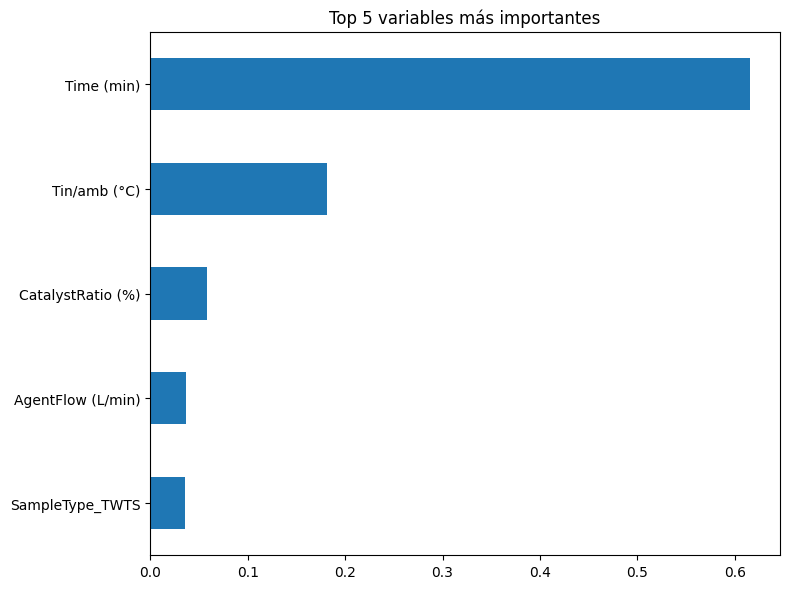

In [8]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

rf = RandomForestRegressor(random_state=1307)
rf.fit(X_train_encoded, y_train)

importances = pd.Series(
    rf.feature_importances_,
    index=X_train_encoded.columns
).sort_values(ascending=False)

print("\n==== Importancia de variables (Random Forest) ====\n")
print(importances)

plt.figure(figsize=(8,6))
importances.head(5).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 5 variables más importantes")
plt.tight_layout()
plt.show()


In [9]:
rfe = RFE(estimator=RandomForestRegressor(random_state=1307), n_features_to_select=3)
rfe.fit(X_train_encoded, y_train)

selected_features = X_train_encoded.columns[rfe.support_]

print("\n==== Variables seleccionadas por RFE ====\n")
print(selected_features)



==== Variables seleccionadas por RFE ====

Index(['Time (min)', 'Tin/amb (°C)', 'CatalystRatio (%)'], dtype='object')


Evidentemente, impactan sobre el tiempo, temperatura ambiente, temperatura del proceso

# 10. (Opcional) PCA tras escalar; evaluar varianza explicada/impacto.

Explicamos impactos de reducción de dimensionalidad

Varianza explicada por componente:
[0.37699596 0.2363327  0.20908455 0.13430714 0.04327965]

Varianza acumulada:
[0.37699596 0.61332866 0.82241321 0.95672035 1.        ]


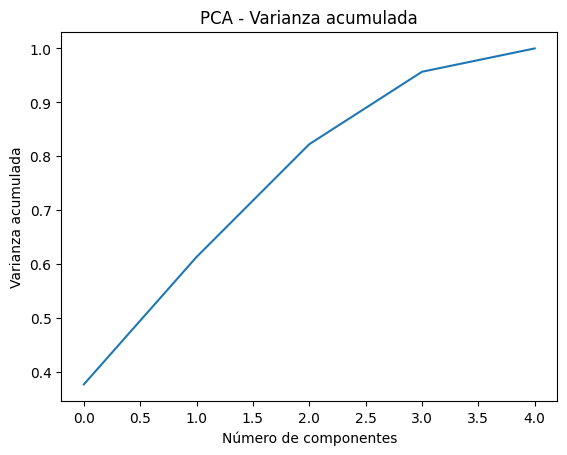

In [10]:
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)

pca = preprocessor.named_transformers_['num'].named_steps['pca']

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Varianza explicada por componente:")
print(explained_variance)

print("\nVarianza acumulada:")
print(cumulative_variance)

plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.title("PCA - Varianza acumulada")
plt.show()


Se observan 5 variables numéricas originalesm por eso aparecen 5 componentes.

Varianza explicada por componente:

- PC1 = 0.3668 → 36.7%
- PC2 = 0.2430 → 24.3%
- PC3 = 0.2209 → 22.1%
- PC4 = 0.1276 → 12.8%
- PC5 = 0.0415 → 4.1%

Varianza acumulada:

- 1 componente → 36.7%
- 2 componentes → 60.9%
- 3 componentes → 83.1%
- 4 componentes → 95.85%
- 5 componentes → 100%

Conclusiones técnicas

- No hay una componente dominante. PC1 no explica >50%, por lo tanto la información está relativamente distribuida.
- Con 3 componentes retienes ~83%. Ya capturas la mayor parte de la estructura.
- Con 4 componentes retienes ~96%. Reduces de 5 → 4 variables manteniendo casi toda la información.
- La quinta componente aporta solo 4%. Es prácticamente ruido o variación residual.

Decisión práctica

- Para conservar 95% de varianza : n_components = 4
- Reducción más agresiva : n_components = 3

Impacto real

- Reducir de 5 → 4 no cambia casi nada.
- Reducir de 5 → 3 sí es una reducción real ( 2/5 = 40% de variables).

Con solo 5 variables numéricas, el beneficio de PCA es limitado, no hay alta redundancia extrema, pero sí algo de correlación moderada.

Conclusión clara:

- PCA no es crítico en este caso.
- Puede usarse con 3 o 4 componentes, pero no es determinante.

# 11. Entrenamiento de modelos 

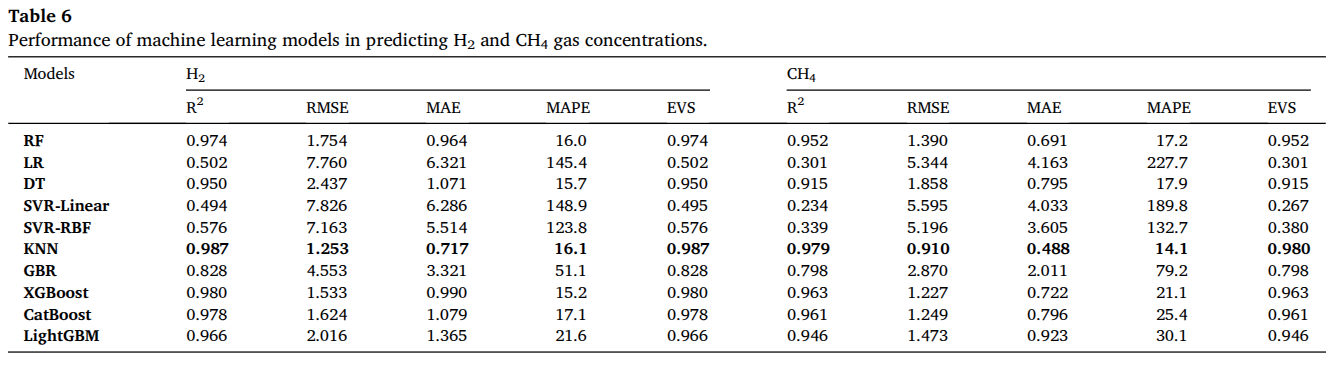

Trataemos de llegar a estos resultados previamente realizados por los autores del artículo

In [11]:
# Random Forest

RF_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=1307,n_jobs=-1))
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__n_estimators': [100, 200, 400, 600, 800],
        'model__max_depth': [None, 10, 20, 30, 40, 50],
        'model__min_samples_split': [2, 5, 10, 15, 20],
        'model__min_samples_leaf': [1, 2, 4, 10],
        'model__max_features': ['sqrt', 'log2', 0.5],
        'model__bootstrap': [True]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__n_estimators': [100, 200, 400, 600, 800],
        'model__max_depth': [None, 10, 20, 30, 40, 50],
        'model__min_samples_split': [2, 5, 10, 15, 20],
        'model__min_samples_leaf': [1, 2, 4, 10],
        'model__max_features': ['sqrt', 'log2', 0.5],
        'model__bootstrap': [True]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

RF_Model_selection = GridSearchCV(
    estimator=RF_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

In [12]:
# Linear regression

LR_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__fit_intercept': [True, False],
        'model__positive': [False, True]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__fit_intercept': [True, False],
        'model__positive': [False, True]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

LR_Model_selection = GridSearchCV(
    estimator=LR_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

In [13]:
# Decision Tree

DT_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=1307))
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__criterion': ['squared_error', 'friedman_mse'],
        'model__splitter': ['best', 'random'],
        'model__max_depth': [None, 5, 10, 15, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': [None, 'sqrt', 'log2', 0.5]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__criterion': ['squared_error', 'friedman_mse'],
        'model__splitter': ['best', 'random'],
        'model__max_depth': [None, 5, 10, 15, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': [None, 'sqrt', 'log2', 0.5]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

DT_Model_selection = GridSearchCV(
    estimator=DT_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)


In [14]:
# SVR-linear

SVR_LIN_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='linear'))
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__C': [0.1, 1, 10, 50, 100],
        'model__epsilon': [0.01, 0.05, 0.1, 0.2],
        'model__max_iter': [5000, 10000, -1]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__C': [0.1, 1, 10, 50, 100],
        'model__epsilon': [0.01, 0.05, 0.1, 0.2],
        'model__max_iter': [5000, 10000, -1]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

SVR_L_Model_selection = GridSearchCV(
    estimator=SVR_LIN_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

In [15]:
# SVR-RBF

SVR_RBF_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf'))
])

param_grid = [
    {
        # Con PCA
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__C': [1, 10, 50, 100],
        'model__epsilon': [0.01, 0.05, 0.1, 0.2],
        'model__gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'model__max_iter': [5000, 10000, -1]
    },
    {
        # Sin PCA
        'preprocessor__num__pca': ['passthrough'],
        'model__C': [1, 10, 50, 100],
        'model__epsilon': [0.01, 0.05, 0.1, 0.2],
        'model__gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'model__max_iter': [5000, 10000, -1]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

SVR_RBF_Model_selection = GridSearchCV(
    estimator=SVR_RBF_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)


In [16]:
# KNN
KNN_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNN())
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [1, 2, 3, 4],
        'model__n_neighbors': [40,30,20,15,10],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],
        'model__p': [1, 2]  # solo se aplica si metric='minkowski'
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__n_neighbors': [40,30,20,15,10],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],
        'model__p': [1, 2]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

KNN_Model_selection = GridSearchCV(
    estimator=KNN_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)


In [17]:
# GBR
GBR_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=1307))
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__subsample': [0.7, 0.85, 1.0],
        'model__max_features': ['auto', 'sqrt', 'log2', None]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__n_estimators': [50, 100, 200, 300, 400, 500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__subsample': [0.7, 0.85, 1.0],
        'model__max_features': ['auto', 'sqrt', 'log2', None]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

GBR_Model_selection = GridSearchCV(
    estimator=GBR_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)


In [18]:
# XGBoost

XGB_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=1307))
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__n_estimators': [50, 100, 200, 300, 400, 500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3, 5],
        'model__subsample': [0.7, 0.85, 1.0],
        'model__colsample_bytree': [0.7, 0.85, 1.0],
        'model__gamma': [0, 0.1, 0.3],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [1, 1.5, 2]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__n_estimators': [50, 100, 200, 300, 400, 500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3, 5],
        'model__subsample': [0.7, 0.85, 1.0],
        'model__colsample_bytree': [0.7, 0.85, 1.0],
        'model__gamma': [0, 0.1, 0.3],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [1, 1.5, 2]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

XGB_model_selection = GridSearchCV(
    estimator=XGB_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

In [19]:
# CatBoost

CATB_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(loss_function='RMSE', random_state=1307, verbose=0))
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__iterations': [500, 1000, 1500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__depth': [3, 5, 7, 9],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__bagging_temperature': [0, 0.5, 1.0],
        'model__border_count': [32, 64, 128]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__iterations': [500, 1000, 1500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__depth': [3, 5, 7, 9],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__bagging_temperature': [0, 0.5, 1.0],
        'model__border_count': [32, 64, 128]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

CATB_Model_selection = GridSearchCV(
    estimator=CATB_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

In [20]:
# light gbm
LGBM_Model_Pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=1307))
])

param_grid = [
    {
        'preprocessor__num__pca__n_components': [None, 0.95, 0.90, 3, 4],
        'model__n_estimators': [500, 1000, 1500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__num_leaves': [31, 50, 70],
        'model__max_depth': [3, 5, 7, -1],
        'model__min_child_samples': [10, 20, 30],
        'model__subsample': [0.7, 0.8, 1.0],
        'model__colsample_bytree': [0.7, 0.8, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [0, 0.1, 0.5]
    },
    {
        'preprocessor__num__pca': ['passthrough'],
        'model__n_estimators': [500, 1000, 1500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__num_leaves': [31, 50, 70],
        'model__max_depth': [3, 5, 7, -1],
        'model__min_child_samples': [10, 20, 30],
        'model__subsample': [0.7, 0.8, 1.0],
        'model__colsample_bytree': [0.7, 0.8, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [0, 0.1, 0.5]
    }
]

cv = KFold(n_splits=10, shuffle=True, random_state=1307)

LGBM_Model_selection = GridSearchCV(
    estimator=LGBM_Model_Pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

In [21]:
scores_model = {}

# 13. Evaluación en test + Intervalos de confianza
Se mide cómo se comporta el modelo en datos que nunca vio y cuantificar la incertidumbre de sus predicciones.

- Evaluación en test: aplicar el modelo a un conjunto de datos separado (test set) para calcular métricas finales como R², MAE, RMSE, accuracy, F1, etc. Esto refleja la capacidad real de generalización.
- IC (Intervalo de Confianza): calcular un rango en el que es probable que caiga la predicción o la métrica con cierto nivel de confianza (por ejemplo 95%). Sirve para entender cuán confiables son las predicciones o métricas, no solo su valor puntual.

In [ ]:
# # Lista de modelos
# model_list = {
#     'RF': RF_Model_selection,
#     'LR': LR_Model_selection,
#     'DT': DT_Model_selection,
#     'SVR_L': SVR_L_Model_selection,
#     'SVR_RBF': SVR_RBF_Model_selection,
#     'KNN': KNN_Model_selection,
#     'GBR': GBR_Model_selection,
#     'XGB': XGB_model_selection,
#     'CATB': CATB_Model_selection,
#     'LGBM': LGBM_Model_selection
# }

# scores_model = {}

# for name, model in model_list.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     h2_true = y_test['Hydrogen (vol%)'].values
#     ch4_true = y_test['Methane (vol%)'].values
    
#     h2_pred = y_pred[:,0] if y_pred.ndim>1 else y_pred
#     ch4_pred = y_pred[:,1] if y_pred.ndim>1 else y_pred

#     scores_model[name] = {
#         'H2': {
#             'r2': r2_score(h2_true, h2_pred),
#             'mae': mean_absolute_error(h2_true, h2_pred),
#             'rmse': np.sqrt(mean_squared_error(h2_true, h2_pred)),
#             'mape': mean_absolute_percentage_error(h2_true, h2_pred),
#             'evs': 1 - np.var(h2_true - h2_pred)/np.var(h2_true)
#         },
#         'CH4': {
#             'r2': r2_score(ch4_true, ch4_pred),
#             'mae': mean_absolute_error(ch4_true, ch4_pred),
#             'rmse': np.sqrt(mean_squared_error(ch4_true, ch4_pred)),
#             'mape': mean_absolute_percentage_error(ch4_true, ch4_pred),
#             'evs': 1 - np.var(ch4_true - ch4_pred)/np.var(ch4_true)
#         }
#     }

In [22]:
Model_selection = KNN_Model_selection

base = Pipeline([('preprocessor', preprocessor), ('model', DummyRegressor(strategy='mean'))]).fit(X_train, y_train)
print(f'\nBaseline R2 test: {r2_score(y_test, base.predict(X_test))}\n')

Model_selection.fit(X_train, y_train)

print(f"Complete details of the model = {Model_selection.best_estimator_}")
print(f"Best scorer                   = {Model_selection.best_score_}")
print(f"Best Hyperparameters chosen    = {Model_selection.best_params_}")
print(f"Best Index                     = {Model_selection.best_index_}")
print(f"Scorer                         = {Model_selection.scorer_}")
print(f"number of splits               = {Model_selection.n_splits_}")
print(f"refit_time                     = {Model_selection.refit_time_}")

Best_model = Model_selection.best_estimator_ 
scores = cross_val_score(estimator=Best_model, X=X_train, y=y_train, cv=cv, scoring='r2', n_jobs=-1)
Yhat = Best_model.predict(X_test)

model_name = type(Best_model.named_steps["model"]).__name__
scores_model[model_name] = {}

for i, name in enumerate(target):
    if name not in ["Methane (vol%)", "Hydrogen (vol%)"]:
        continue
    y_true = y_test.iloc[:, i].values
    y_pred = Yhat[:, i]
    scores_model[model_name][name] = {
        "r2": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "evs": 1 - np.var(y_true - y_pred) / np.var(y_true)
    }
    print(f'{name}: R2={scores_model[model_name][name]["r2"]:.3f}  MAE={scores_model[model_name][name]["mae"]:.3f}')

res = y_test.values - Yhat
print(res.mean(axis=0), res.std(axis=0))

y_pred_test = Yhat


Baseline R2 test: -0.0008966408984648991

Complete details of the model = Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   'passthrough')]),
                                                  ['Time (min)', 'Tin/amb (°C)',
                                                   'ProcessTemperature (°C)',
                                                   'AgentFlow (L/min)',
                                                   'CatalystRatio (%)']),
                                             

In [23]:
print(json.dumps(scores_model, indent=4, default=lambda x: float(x) if isinstance(x, (np.floating, np.integer)) else x))

{
    "KNeighborsRegressor": {
        "Methane (vol%)": {
            "r2": 0.9596183408790883,
            "mae": 0.6511506383758883,
            "rmse": 1.2632215202231794,
            "mape": 605272237.529221,
            "evs": 0.9600660533636639
        },
        "Hydrogen (vol%)": {
            "r2": 0.9783218744657247,
            "mae": 0.9259258406527632,
            "rmse": 1.6048934832264798,
            "mape": 565801744.6332465,
            "evs": 0.9787839504255654
        }
    }
}


In [24]:
# rows = []

# for model_name, gases in scores_model.items():
#     row = {'Models': model_name}

#     for metric, value in gases['H2'].items():
#         row[f'H2_{metric.upper()}'] = value

#     for metric, value in gases['CH4'].items():
#         row[f'CH4_{metric.upper()}'] = value
    
#     rows.append(row)

# df_scores = pd.DataFrame(rows)

# cols = ['Models', 
#         'H2_R2', 'H2_RMSE', 'H2_MAE', 'H2_MAPE', 'H2_EVS',
#         'CH4_R2', 'CH4_RMSE', 'CH4_MAE', 'CH4_MAPE', 'CH4_EVS']

# df_scores = df_scores[cols]

# display(df_scores)

In [25]:
print('\n=== SCORES ===\n')
row = 0 
for i in scores:
    row += 1
    print(f'Fold {row}: {i:.3f}')
print("\nMean:", scores.mean())
print("Standard deviation:", scores.std())
print(f'Score on the TEST set:, {r2_score(y_test, y_pred_test):.3f}') 


=== SCORES ===

Fold 1: 0.961
Fold 2: 0.970
Fold 3: 0.964
Fold 4: 0.972
Fold 5: 0.967
Fold 6: 0.969
Fold 7: 0.971
Fold 8: 0.971
Fold 9: 0.970
Fold 10: 0.973

Mean: 0.9688461096850164
Standard deviation: 0.00364880978798905
Score on the TEST set:, 0.971


In [26]:
Time= 29
Temperature= 500
ProcessTemperature= 1000
AgentType='Oxygen'
AgentFlow=0.015
SampleType='TWTS'
CatalystType='Marble dust'
CatalystRatio=10

eval = [Time, Temperature, ProcessTemperature, AgentType, AgentFlow, SampleType, CatalystType, CatalystRatio]
sample_df = pd.DataFrame([eval], columns=X.columns)

resultado = Best_model.predict(sample_df)
print('\nPredicciones:\n')
print(f'CarbonMonoxide (vol%) = {resultado[0][0]:.3f}'.replace('.', ','))        
print(f'CarbonDioxide (vol%) = {resultado[0][1]:.3f}'.replace('.', ','))        
print(f'Methane (vol%) = {resultado[0][2]:.3f}'.replace('.', ','))        
print(f'Oxygen (vol%) = {resultado[0][3]:.3f}'.replace('.', ','))
print(f'Hydrogen (vol%) = {resultado[0][4]:.3f}'.replace('.', ','))
print(f'CalorificValue (kcal/m3) = {resultado[0][5]:.3f}'.replace('.', ','))


Predicciones:

CarbonMonoxide (vol%) = 3,747
CarbonDioxide (vol%) = 12,916
Methane (vol%) = 5,689
Oxygen (vol%) = 8,250
Hydrogen (vol%) = 5,188
CalorificValue (kcal/m3) = 810,879


# 14. Interpretabilidad y análisis de errores.
Significa entender qué está haciendo el modelo y por qué se equivoca.

- Interpretabilidad: analizar qué variables influyen más en las predicciones. Ejemplos: SHAP o LIME para explicar predicciones individuales.
- Análisis de errores: estudiar dónde y por qué el modelo falla. Por ejemplo:
- Revisar ejemplos con mayor error (residuals grandes).
- Detectar patrones de errores según características de los datos.
- Identificar sesgos, outliers o regiones del espacio de entrada donde el modelo no generaliza.

# 15. Empaquetado, versionado, reproducibilidad y monitoreo.
Persistencia del modelo y guardado

In [ ]:
# dump(Best_model, 'Best_model.joblib')   # guardar
# modelo = load('../models/Best_model.joblib')    # cargar

# from joblib import Memory
# memory = Memory(location='.cache_sklearn', verbose=0)
# Model_Pipeline = Pipeline([...], memory=memory)  # cachea transformaciones en GridSearchCV
# np.random.seed(1307)